# Volume 3: Intro to Deep Learning
    <Name>
    <Class>
    <Date>

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

#assert torch.cuda.is_available()

# Problem 1
Create the device variable.
Download the CIFAR10 training and test datasets.
Transform them into tensors and normalize them.

In [3]:
# Create the device, choosing GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Transform data into a tensor and normalize
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))])

# Download the CIFAR10 training data to ../data
train_data = datasets.CIFAR10('../data', train=True, download=True, transform=transform)

# assign test data
test_data = datasets.CIFAR10('../data', train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:13<00:00, 12862287.05it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


# Problem 2
Split the data into train, validation, and test sets, and create DataLoaders for each one. Use a batch size of 32 for the training set and 1 for the validation and test sets.

In [4]:
# Create a DataLoader from the shuffled training data
# batch size 32, shuffle true
actual_train_data = [train_data[i] for i in range(40000)]
train_loader = DataLoader(actual_train_data, batch_size=36, shuffle=True)

# and similarly for the validation set
# next 10,000 data points, batch size 1, shuffled false
actual_val_data = [train_data[i] for i in range(40000, 50000)]
val_loader = DataLoader(actual_val_data, batch_size=1, shuffle=False)

# and similarly for the test set
# next 10,000 data points, batch size 1, shuffled false
actual_test_data = [test_data[i] for i in range(10000)]
test_loader = DataLoader(actual_test_data, batch_size=1, shuffle=False)

# Problem 3

Create a class for a convolutional neural network that accepts images as $3\times 32 \times 32$ tensors and returns a 1D tensor of length 10, representing its predicted probabilities of each class.

The model should have at least three convolution layers, each followed by an activation function, a max pooling layer, and at least two linear layers.
Be sure that your final activation function is the softmax function.
Choose the size of the layers so that your model has at least 50,000 parameters, and record this calculation in the Jupyter notebook.

In [5]:
class CNNExample(nn.Module):
    def __init__(self):
        super().__init__()
        channel_list = [3, 64, 64, 1]

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=channel_list[0], out_channels=channel_list[1], kernel_size=(3,3), stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=channel_list[1], out_channels=channel_list[2], kernel_size=(3,3), stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=channel_list[2], out_channels=channel_list[3], kernel_size=(3,3), stride=1)
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=1)
        self.flatten = nn.Flatten()
        # Linear layers
        self.linear1 = nn.Linear(in_features = 529, out_features = 32)
        self.linear2 = nn.Linear(in_features = 32, out_features = 10)
        # Activation function
        self.relu = nn.ReLU()
        # Softmax layer
        self.softmax = nn.Softmax(dim=1)



    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.pool(x1)
        x3 = self.conv2(x2)
        x4 = self.pool(x3)
        x5 = self.conv3(x4)
        x6 = self.pool(x5)
        x7 = self.flatten(x6)
        x8 = self.linear1(x7)
        x9 = self.relu(x8)
        x10 = self.linear2(x9)

        return x10

In [6]:
# Get the 36 images of size 3x32x32 and labels in the first batch
dataiter = iter(train_loader)
images, labels = next(dataiter)

model = CNNExample()
print(model(images[0].unsqueeze(0)))

x = torch.rand(3,32,32)
model.forward(x)
total_params = sum(p.numel() for p in model.parameters())
print(f"\nNumber of parameters: {total_params}")


tensor([[ 0.0320, -0.1813, -0.0563,  0.0940, -0.1224,  0.0143,  0.1077,  0.0795,
          0.0857, -0.0354]], grad_fn=<AddmmBackward0>)

Number of parameters: 56587


# Problem 4
Send your model to the device and instantiate the objective and optimizer.
Train your model with a TQDM display, and calculate the Validation Accuracy after each epoch.
Begin by initializing your TQDM loop, then for each epoch, do the following:

1. Set your model to training mode (model.train())
2. Instantiate an empty loss_list
3. For each batch in train_loader:
    - Send x and y_truth to device
    - Zero out the gradients
    - Use model to predict labels of x
    - Calculate loss between predicted labels and y_truth
    - Append loss (loss.item()) to loss_list
    - Update TQDM loop
    - Backpropagate to compute gradients
    - Optimize and update the weights
4. Save the loss mean as the mean of the losses in loss_list
5. Set your model to evaluation mode (model.eval())
6. Calculate and save validation accuracy
Finish the training by closing your TQDM loop.

Train for 10 epochs, saving the mean loss and validation accuracy for each epoch.
Plot the mean losses and validation accuracies.

Finally, print the final test score.

In [7]:
# Send model to the device & instantiate the objective & optimizer
model.to(device)
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# initialize
loss_list, epoch_loss_list, val_list = [], [], []

# iterate
for epoch in range(10):
    loop = tqdm(total=len(train_loader), position=0)

    # Set model to training mode
    model.train()

    # Instantiate an empty loss_list
    epoch_loss = 0

    # For each batch in train_loader
    for batch in train_loader:
        # Send x and y_truth to device
        x, y = batch
        x, y = x.to(device), y.to(device)
        # Zero out the gradients
        optimizer.zero_grad()
        # Use model to predict labels of x
        pred = model(x)
        # Calculate loss between predicted labels and y_truth
        loss = objective(pred, y)
        loss.backward()
        optimizer.step()
        # Append loss (loss.item()) to loss_list
        loss_list.append(loss.item())
        loop.set_description(f'epoch: {epoch}, loss: {loss.item()}')

        epoch_loss += loss.item()
    # Save the loss mean as the mean of the losses in loss_list
    epoch_loss_list.append(epoch_loss / len(train_loader))

    # Set your model to evaluation mode
    model.eval()
    # Calculate and save validation accuracy
    val_score = 0
    for x,y in val_loader:
      x, y = x.to(device), y.to(device)

      pred = model(x)
      if y == pred.argmax(1):
        val_score += 1
    val_acc = val_score / len(val_loader)
    val_list.append(val_acc)

    loop.close()

epoch: 9, loss: 1.6061348915100098:   0%|          | 0/1112 [00:17<?, ?it/s]


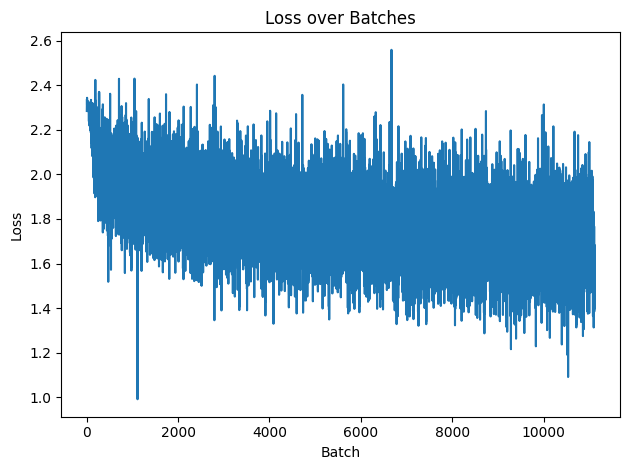

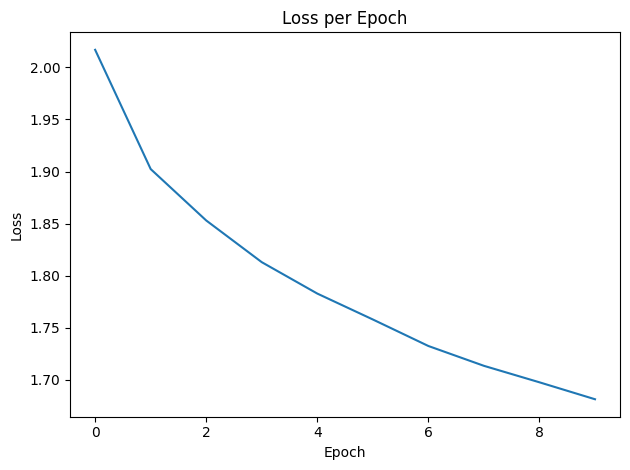

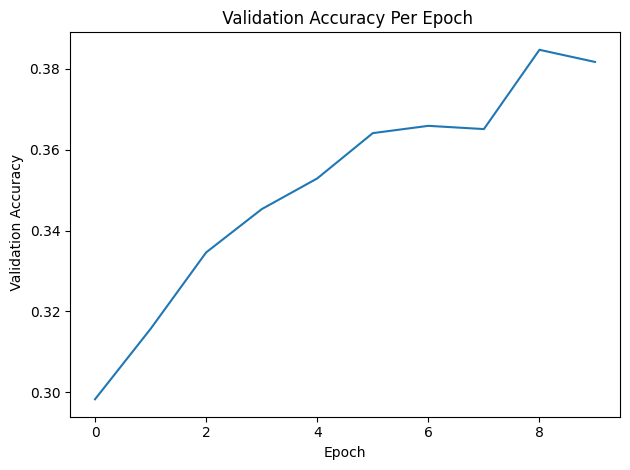

final test acc: 0.3891


In [9]:
model.eval()
test_score = 0
for x,y in test_loader:
  x, y = x.to(device), y.to(device)
  pred = model(x)
  if y == pred.argmax(1):
    test_score += 1
test_acc = test_score / len(test_loader)

# plot
plt.plot(loss_list)
plt.xlabel("Batch")
plt.ylabel("Training Loss")
plt.title("Training Loss over Batches")
plt.tight_layout()
plt.show()

plt.plot(epoch_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Mean Training Losses Per Epoch")
plt.tight_layout()
plt.show()

plt.plot(val_list)
plt.xlabel("Epochs")
plt.ylabel(" Validation Accuracy")
plt.title(" Validation Accuracy Per Epoch")
plt.tight_layout()
plt.show()


print(f"Final Test Accuracy: {test_acc}")

# Problem 5

Write a function that loops through the test data, modifying the images as described.

Run your function for each epsilon in $[0,.05,.1,.15,.2,.25,.3]$, and plot epsilon v. accuracy.

Display the perturbed version of the first image in the test data for each epsilon.

In [8]:
# FGSM attack code
def fgsm_attack(model, optimizer, objective, x, y, eps):
    """
    Performs the FGSM attack on the given model and data point x with label y.
    Returns the perturbed data point.
    """
    # Calculate the gradient
    x.requires_grad = True
    x.retain_grad()
    optimizer.zero_grad()
    output = model(x)
    loss = objective(output, y)
    loss.backward()
    data_grad = x.grad.data
    # Perturb the images
    x_perturbed = x + eps * data_grad.sign()
    return x_perturbed

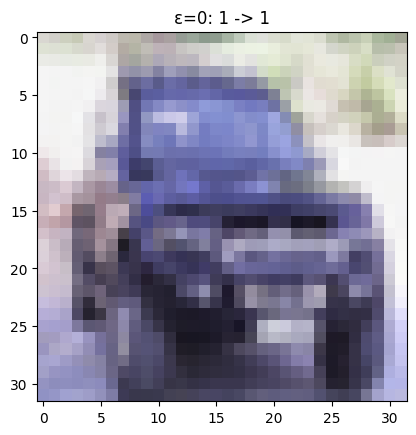

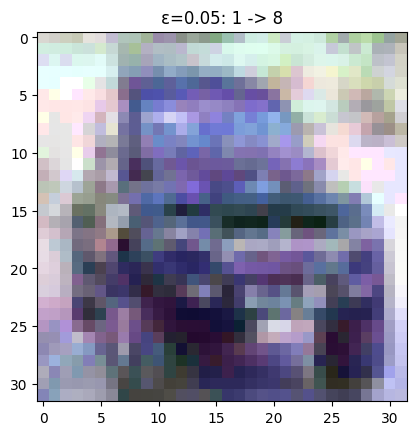

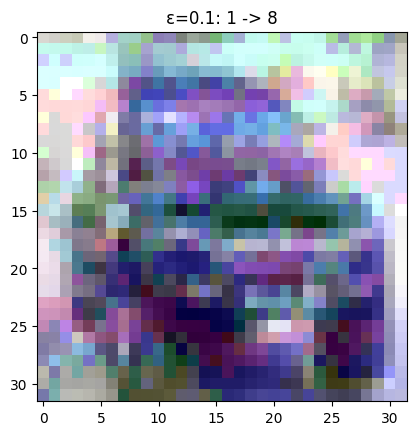

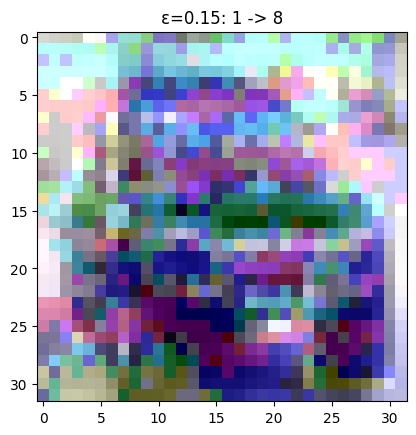

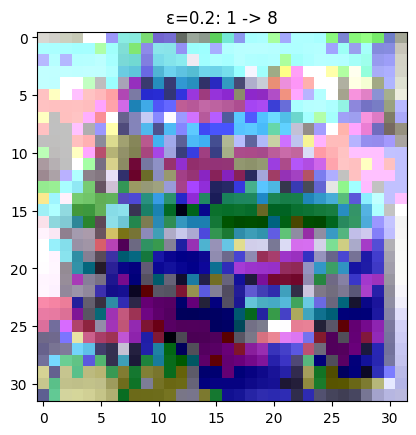

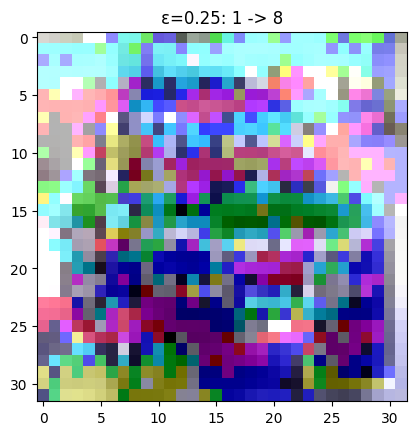

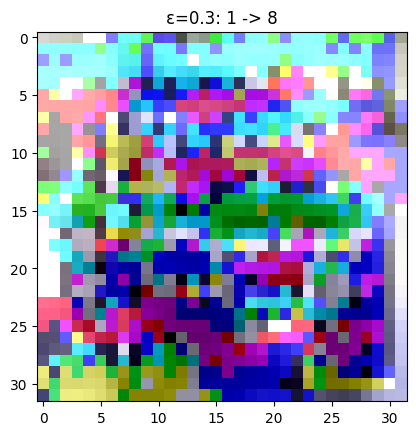

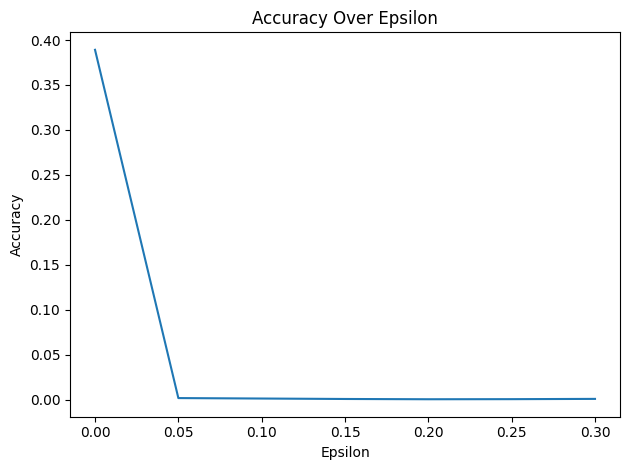

In [12]:
def perturber(eps):
  # initialize
  test_score = 0
  i = 0

  # iterate
  for x,y in test_loader:
    i += 1
    x,y = x.to(device), y.to(device)

    x_perturbed = fgsm_attack(model, optimizer, objective, x, y, eps)
    # Clip the perturbed images to ensure they are within the valid range
    x_perturbed = torch.clamp(x_perturbed, 0, 1)

    pred = model(x_perturbed)
    if y == pred.argmax(1):
      test_score += 1


    if i == 10:
      # Move the image to cpu and convert to numpy array
      ex = x_perturbed.squeeze().detach().cpu().numpy()
      # Plot the image
      plt.imshow(np.transpose(ex, (1,2,0)))
      plt.title(f"ε={eps}: {y.item()} -> {pred.argmax(1).item()}")
      plt.show()
      first_image = False
  return test_score / len(test_loader)


accs = []
epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
for eps in epsilons:
  accs.append(perturber(eps))

plt.plot(epsilons, accs)
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epsilon")
plt.tight_layout()
plt.show()
